### Importing the Libraries

At first, we will load the libraries, that we will use to conduct the analysis.

In [57]:
# Basic imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

Now, we will load the data. In total, we have 55 files that need to be loaded and merged. We will do this in the next step.

In [58]:
df = pd.read_csv("data/Kickstarter000.csv")

for i in range(1,56):
    
    num = str(1000 + i)
    
    dfi = pd.read_csv(f"data/Kickstarter{num[1:4]}.csv")
    df = pd.concat([df,dfi], axis = 0)
    
df.to_csv("data/kickstarter_raw.csv")

The new data set contains 209222 observations and 37 columns.

In [99]:
df = pd.read_csv("data/kickstarter_raw.csv", index_col=0)

### Data Preparation

At first we need to get a overview of the data to see where data cleaning is needed.

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209222 entries, 0 to 964
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     obje

As we can see from above "blurb", "friends", "is_backing", "is_starred", "location", "permissions" and "usd_type" contain missing values. The variables "friends", "is_backing", "is_starred" and "permissions" have more than 90% missings. We will delete them from our dataset and take care of of the other variables with missings later. 

Further variables that can be delete as they do not have any valuable information for our analysis are " " ... In the next step, we will delete them together with the variables that have more than 90% missings.

In [61]:
# Exclusion of the following columns from our data

df = df.drop(["currency_symbol",
         "currency_trailing_code",
         "friends",
         "is_backing",
         "is_starred",
         "permissions", 
         "photo",
         "source_url",
         "urls",
         "state_changed_at",
         "spotlight",
         "disable_communication",
         "is_starrable"], axis=1)



Further, we can see from above that the type of the columns "created_at", "deadline" and "launched_at" is not correct (integer instead of datetime format). In the next step, we will change that. Further, we will extract year, month and weekday out of the variables "launched_at" and "dealine" since we will later on explore these in more depth. 

In [62]:
# convert unix date time to pandas datetime format
df['created_at'] = pd.to_datetime(df['created_at'],unit='s')
df['deadline'] = pd.to_datetime(df['deadline'],unit='s')
df['launched_at'] = pd.to_datetime(df['launched_at'],unit='s')

# pick out year, month and weekday out of date of launching
df['yr_launched'] = df['launched_at'].dt.year
df['mo_launched'] = df['launched_at'].dt.month
df['wd_launched'] = df['launched_at'].dt.weekday

# pick out year, month and weekday out of date of deadline
df['yr_deadline'] = df['deadline'].dt.year
df['mo_deadline'] = df['deadline'].dt.month
df['wd_deadline'] = df['deadline'].dt.weekday

For our analysis it could be interesting to investigate the duration between deadline and launched date in more depth. Thus, in the next step, we will calculation the duration between the aformentioned variables.

In [63]:
# calculate duration of founding_phase (time between launching and deadline)
founding_phase = df['deadline'] - df['launched_at']
df['founding_phase'] = founding_phase.dt.days

# calculate duration of phase_before (time between creation and launcing)
phase_before = df['launched_at'] - df['created_at']
df['phase_before'] = phase_before.dt.days

The original variables "deadline" and "launched_at" are no longer needed. We can delete them.

In [64]:
# drop columns created_at, deadline, launched_at
df = df.drop(["created_at", "deadline", "launched_at"], axis=1)

At next, we will create dummy variables of some categorical variables. Encoding of categorical variables simplifies.... 

The first variable we would like to encode is "state". Contains info about ... and is our target. Before, we encode we will explore this variable in more depth...

In [65]:
# Counts
df.state.value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

We can see X levels. Overall most of the observations were successful.... For our research question only X relevant.. So exlusion of other levels....

Balanced (more or less)

In [66]:
df = df.query('state in ["successful", "failed"]')

# Prove if it works
df.state.value_counts()

successful    117465
failed         75199
Name: state, dtype: int64

After dropping rows and colums the data set contains X observations and Y columns

After exploration, we encode state... As well as staff_pick...



In [67]:
# Encoding of the state (target) variable:
df['state'] = df['state'].apply(lambda x: 1 if x == 'successful' else 0)

# 0 = failed
# 1 = sucessful

In [68]:
df['staff_pick'] = df['staff_pick'].apply(lambda x: 1 if x == True else 0)

Now, let's have a look at the frequency distribution of the individual variables in our data set. For this purpose, we will use histograms.

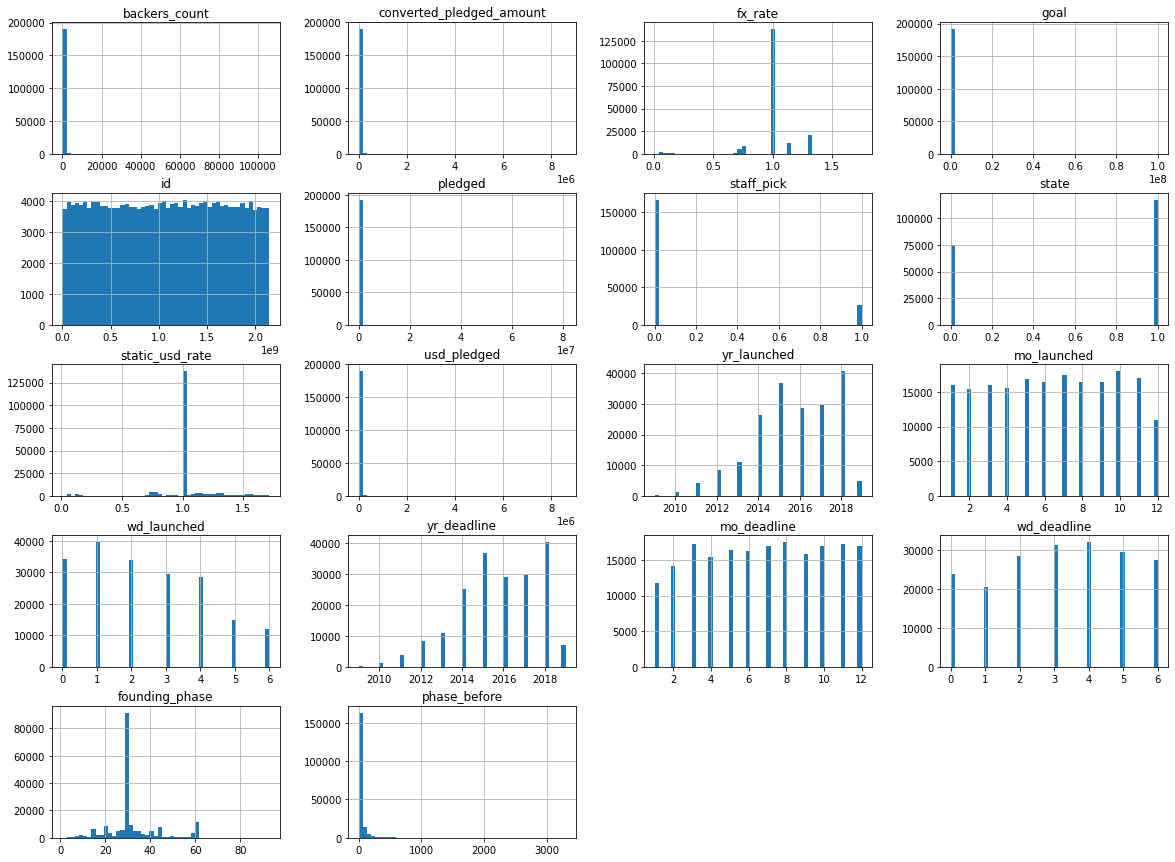

In [69]:
df.hist(bins=50, figsize = (20,15));

A first glance on the distribution reveals that the variables "bakers_Count"... (--> outliers). We can also see, which vars are categorical. The information from the above printed histograms can be summarised as:
- ...
- 


As outliers can strongly affect our analysis we exclude... Before we do this we need to create a variable....

In [70]:
df["goal_usd"] = df["goal"]*df["static_usd_rate"]

In [71]:
# get 98.5% quantile (highest 1.5%) of 'phase_before', 'usd_pledged', 'goal_usd'
q_hi1  = df["phase_before"].quantile(0.985)
q_hi2  = df["usd_pledged"].quantile(0.985)
q_hi3  = df["goal_usd"].quantile(0.985)

# remove highest 1.5% percent of the data with the 98.5% quantiles
df = df[(df["phase_before"] < q_hi1) & (df["usd_pledged"] < q_hi2) & (df["goal_usd"] < q_hi3)]


Now, we come back to our variables that contain missing values.

In [72]:
df.isnull().sum()

backers_count                 0
blurb                         2
category                      0
converted_pledged_amount      0
country                       0
creator                       0
currency                      0
current_currency              0
fx_rate                       0
goal                          0
id                            0
location                    215
name                          0
pledged                       0
profile                       0
slug                          0
staff_pick                    0
state                         0
static_usd_rate               0
usd_pledged                   0
usd_type                     37
yr_launched                   0
mo_launched                   0
wd_launched                   0
yr_deadline                   0
mo_deadline                   0
wd_deadline                   0
founding_phase                0
phase_before                  0
goal_usd                      0
dtype: int64

As shown above, the variables city/region/city_type and usd_type contain a relative low proportion of missings. As large dataset, deletion of the rows with missings should not be a problem.

In [73]:
# Drop rows which contain any NaN value in the selected columns
df = df.dropna( how='any',
                    subset=['location', 'usd_type', "blurb"])

In [74]:
df.isnull().sum()

backers_count               0
blurb                       0
category                    0
converted_pledged_amount    0
country                     0
creator                     0
currency                    0
current_currency            0
fx_rate                     0
goal                        0
id                          0
location                    0
name                        0
pledged                     0
profile                     0
slug                        0
staff_pick                  0
state                       0
static_usd_rate             0
usd_pledged                 0
usd_type                    0
yr_launched                 0
mo_launched                 0
wd_launched                 0
yr_deadline                 0
mo_deadline                 0
wd_deadline                 0
founding_phase              0
phase_before                0
goal_usd                    0
dtype: int64

Lets have a look at main_category relative large proportion of missings...

In [75]:
# Explore

Inspection object types... category; text; probably important info -> extraction of content

In [76]:
df["category_dict"] = df["category"].apply(eval)
df_category = df["category_dict"].apply(pd.Series)
#df_category.head()

In [77]:
print(df_category.shape)
all_categories = df_category[["id", "name"]].drop_duplicates("name")
all_categories.rename(columns = {"id": "parent_id"}, inplace = True)
#all_categories.head()

(184113, 7)


In [78]:
df_category = df_category.merge( all_categories, how = "left", on = "parent_id", suffixes = ["", "_parent"])
df["main_category"] = df_category["name_parent"]
df["subcategory"] = df_category["name"]

As we can see Why missings? Main = subcategory.... Thus, we imputate missings with corresponding sub_category values

In [79]:
# Imputation missing values
df["main_category"].fillna(df["subcategory"], inplace = True) 

In [80]:
# Drop "category_dict" column
df = df.drop(["category", "category_dict"], axis=1)

In [81]:
# Extract name, state and type from location var...
# Rename name var into 
# Drop location

df["location"].fillna("{}", inplace = True)

df["location"] = df["location"].str.replace(',"is_root":false', "")
df["location"] = df["location"].str.replace(',"is_root":true', "" )
df["location"] = df["location"].str.replace('null', "{}" )

df["location_dict"] = df["location"].apply(eval)
df_location = df["location_dict"].apply(pd.Series)
df_location.head()

df["city"] = df_location["name"]
df["region"] = df_location["state"]
df["city_type"] = df_location["type"]

In [82]:
# Drop "location" column
df = df.drop(["location", "location_dict"], axis=1)

In [83]:
df["creator_id"] = df["creator"].str[6:22]
df["creator_id"] = df["creator_id"].str.replace('"', "")
df["creator_id"] = df["creator_id"].str.split(",").str[0]
df["creator_id"] = df["creator_id"].astype(int)

df_creator = df[["creator_id","state"]].groupby("creator_id").count()
df_creator.rename(columns = {"state": "creator_num_projects"}, inplace = True)
df_creator.reset_index()

df = df.merge( df_creator, how = "left", on = "creator_id")

Extract number of words: sentimental analysis...

In [84]:
# Extract number of words
df['words_blurb'] = df['blurb'].apply(lambda x: len(str(x).split()))

In [86]:
!pip install TextBlob

from textblob import TextBlob

     |████████████████████████████████| 636 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 7.3 MB/s eta 0:00:011
     |████████████████████████████████| 284 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 5.5 MB/s eta 0:00:01


In [87]:
a = TextBlob(df.loc[1000, "blurb"])
print(df.loc[1000, "blurb"])
a.sentiment

Professional high quality Film Holders,  CNCed aluminum body, available in 4x5", 8x10"and 11x14". Proudly 100% Made in Sassuolo, Italy


Sentiment(polarity=0.365, subjectivity=0.51)

In [88]:
df['polarity_blurb'] = df['blurb'].apply(lambda x: TextBlob(str(x)).sentiment[0])
df['subjectivity_blurb'] = df['blurb'].apply(lambda x: TextBlob(str(x)).sentiment[1])

In [89]:
df = df.drop(["creator",
             "blurb",
             "static_usd_rate",
             "fx_rate",
             "currency",
             "current_currency",
             "pledged",
             "goal",
             "profile",
             "converted_pledged_amount",
             "slug"], axis=1)

In [95]:
df.to_csv("data/data_clean.csv")
df = pd.read_csv("data/data_clean.csv", index_col=0)

# Fehleranalyse (research outlier)
# usd_type keep? delete? (feature importance)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184113 entries, 0 to 184112
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0.1          184113 non-null  int64  
 1   backers_count         184113 non-null  int64  
 2   country               184113 non-null  object 
 3   id                    184113 non-null  int64  
 4   name                  184113 non-null  object 
 5   staff_pick            184113 non-null  int64  
 6   state                 184113 non-null  int64  
 7   usd_pledged           184113 non-null  float64
 8   usd_type              184113 non-null  object 
 9   yr_launched           184113 non-null  int64  
 10  mo_launched           184113 non-null  int64  
 11  wd_launched           184113 non-null  int64  
 12  yr_deadline           184113 non-null  int64  
 13  mo_deadline           184113 non-null  int64  
 14  wd_deadline           184113 non-null  int64  
 15  

Final data set... --> Describe